# WaveNet

* `Wavenet: A generative model for raw audio`, [arXiv:1609.03499](https://arxiv.org/abs/1609.03499)
  * Aa ̈ron van den Oord, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) and [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"

ModuleNotFoundError: No module named 'utils'

## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'wavenet'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'toy_data'
assert dataset_name in ['toy_data']

max_epochs = 10
save_model_epochs = 1
print_steps = 1
save_images_epochs = 1
batch_size = 1#128
learning_rate = 5e-2
num_examples_to_generate = 16
MNIST_SIZE = 28
hidden_dims = 500

## Load or make the dataset

In [3]:
# Load training and eval data from tf.keras
N = 10
T = 5
if dataset_name == 'toy_data':
  x = np.array(range(T))
  n = np.random.random(N)*T/2
  train_sequence = np.array([np.sin(x*i/T) for i in n])

train_sequence = np.expand_dims(train_sequence, axis=-1)

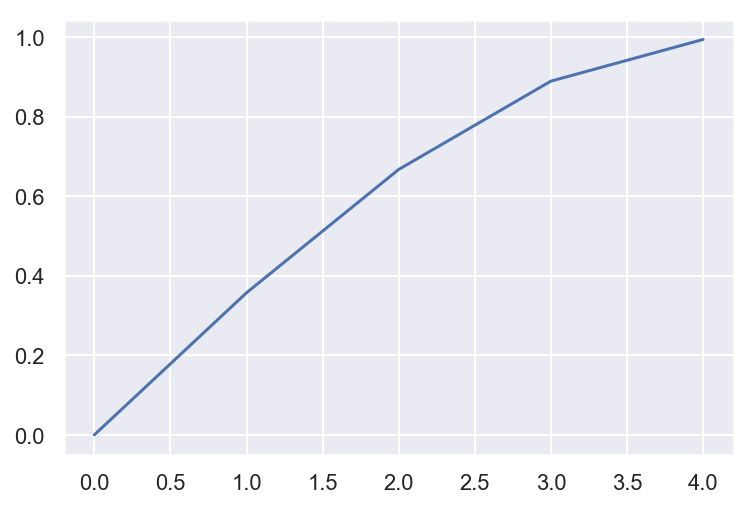

In [4]:
index = 9
plt.plot(train_sequence[index, :, 0])
plt.show()

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [5]:
#tf.random.set_seed(219)

# for train
N = len(train_sequence)
train_dataset = tf.data.Dataset.from_tensor_slices(train_sequence)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (1, 5, 1), types: tf.float64>


## Create the generator and discriminator models

In [8]:
def log_pmf(sample, probability):
  epsilon = 1e-10
  return sample * tf.math.log(probability + epsilon) + (1.-sample) * tf.math.log(1.-probability + epsilon)

In [6]:
for sequence in train_dataset.take(1):
  pass
conv = layers.Conv1D(1, 3, padding='causal',
                     dilation_rate=2,
                     bias_initializer=tf.keras.initializers.zeros)

In [7]:
np.squeeze(sequence.numpy())

array([0.        , 0.41976084, 0.76197905, 0.96343648, 0.98691782])

In [47]:
output = conv(sequence)
np.squeeze(output.numpy())

array([0.34217189, 0.63443911, 0.89326534, 0.43199906, 0.56111388])

In [48]:
np.squeeze(conv.trainable_variables[0].numpy())

array([0.1332241 , 0.63072436, 0.77045887])

In [49]:
tf.reduce_sum(sequence[0, :3, 0] * conv.trainable_variables[0][:, 0, 0])

<tf.Tensor: id=943, shape=(), dtype=float64, numpy=0.48601986326007884>

In [ ]:
class Block():

In [ ]:
b1, skip_b1 = Block() #dilation_rate 만 다르게
b2, skip_b1 = Block(b1)
b3, skip_b1 = Block(b2)
b4, skip_b1 = Block(b3)

skip_b1 + skip_b2 + ... = outputs

tf.nn.softmax(outputs)

-----------

In [ ]:
class MaskedConv2D(layers.Layer):
  def __init__(self, filters, kernel_size, **kwargs):
    self.filters = filters
    self.kernel_size = kernel_size
    super(MaskedConv2D, self).__init__(**kwargs)

  def build(self, input_shape):
    assert len(input_shape) == 4
    
        
    shape = tf.TensorShape((input_shape[1], self.output_dim))
    # Create a trainable weight variable for this layer.
    self.kernel = self.add_weight(name='kernel',
                                  shape=shape,
                                  initializer='uniform',
                                  trainable=True)
    # Make sure to call the `build` method at the end
    super(MaskedConv2D, self).build(input_shape)

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.output_dim
    return tf.TensorShape(shape)

  def get_config(self):
    base_config = super(MyLayer, self).get_config()
    base_config['output_dim'] = self.output_dim
    return base_config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
class PixelCNN(tf.keras.Model):
  def __init__(self):
    """Initiailize learnable parameters.
    
    Args:
      hidden_dims (int): number of hidden unit in every dense layer (input to hidden)
    
    Values:
      self.W (float32 2-rank Tensor): shared training weight of dense layer (input to hidden)
      self.c (float32 1-rank Tensor): shared training bais of dense layer (input to hidden)
      self.models (list): list of 783 dense layers
    """
    super(PixelCNN, self).__init__()
    self.conv = layers.Conv2D(1, 3, padding='same')
    self.c = tf.Variable(tf.zeros(shape=[self.hidden_dims]), name='shared_bias')
    self.models = []
    for i in range(0, MNIST_SIZE**2):
      self.models.append(tf.keras.Sequential([layers.InputLayer(input_shape=[self.hidden_dims]),
                                              layers.Dense(units=1, activation='sigmoid')]))
      
  def call(self, inputs):
    """Build a log likelihood function.
    Implement using papers' algorithm in order to reduce computation of p(x)
    
    Args:
      inputs (float32 2-rank Tensor): MNIST data in one batch
      
    Returns:
      logpx (float32 2-rank Tensor): log likelihood of corresponding batch data
    """
    a = tf.stack([self.c] * batch_size)
    logpx = 0.
    for i in range(MNIST_SIZE**2):
      h = tf.math.sigmoid(a)
      probability = self.models[i](h)
      logpx += log_pmf(inputs[:, i:i+1], probability)
      a = a + tf.matmul(inputs[:, i:i+1], self.W[i:i+1, :])
      
    return logpx

  
  def sampling(self, num_samples):
    """Sample images
    
    Args:
      num_samples (int): number of sample images
      
    Returns:
      samples (float32 2-rank Tensor): sampling images
    """
    h = tf.math.sigmoid(tf.stack([self.c] * num_samples))
    init_pixel_probability = self.models[0](h)
    samples = tf.Variable(tf.zeros(shape=[num_samples, MNIST_SIZE**2], dtype=tf.int32),
                          name='sample_pixel')
    samples[:, 0:1].assign(tf.random.categorical(tf.math.log(tf.concat((1. - init_pixel_probability,
                                                                        init_pixel_probability), axis=1)),
                                                 num_samples=1, dtype=tf.int32))
    
    for i in range(1, MNIST_SIZE**2):
      h = tf.math.sigmoid(tf.matmul(tf.cast(samples[:, :i], dtype=tf.float32), self.W[:i, :]) + self.c)
      probability_ith_pixel = self.models[i](h).numpy() # actually i+1 th pixel
      samples[:, i:i+1].assign(tf.random.categorical(tf.math.log(tf.concat((1. - probability_ith_pixel,
                                                                            probability_ith_pixel), axis=1)),
                                                     num_samples=1, dtype=tf.int32))
    return samples

In [ ]:
nade = NeuralAutoregressiveDensityEstimation(hidden_dims=hidden_dims)

## Define the loss functions and the optimizer

* Actually we use the log likelihood function as loss function

### Define optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
#optimizer = tf.keras.optimizers.SGD(learning_rate)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, nade=nade)

## Training

### Define training one step function

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    log_likelihood = nade(images)
    loss = -tf.reduce_mean(log_likelihood) # expected negative_log_likelihood
      
  gradients = tape.gradient(loss, nade.variables)
  optimizer.apply_gradients(zip(gradients, nade.trainable_variables))

  return loss

### Training full steps

In [ ]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()

    loss = train_step(images)
    global_step.assign_add(1)
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss.numpy(), examples_per_sec, duration))
      sample_images = nade.sampling(num_examples_to_generate)
      print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate)
      
  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = nade.sampling(num_examples_to_generate)
    print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                is_square=True, is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)
      
  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    
print('Training Done.')

In [ ]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = nade.sampling(num_examples_to_generate)
print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                            is_square=True, is_save=True, epoch=epoch+1,
                            checkpoint_dir=checkpoint_dir)

## Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [ ]:
display_image(max_epochs, checkpoint_dir=checkpoint_dir)

## Generate a GIF of all the saved images.

In [ ]:
filename = model_name + '_' + dataset_name + '.gif'
generate_gif(filename, checkpoint_dir)

In [ ]:
display.Image(filename=filename + '.png')